#  Initial Data Exploration

In [1]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
### Include all quantitative features. In addition, 'std_from_poi' and
### 'std_to_poi' are standardized feature (see details below).
features_list = ['poi','salary', 'deferral_payments',
                 'loan_advances', 'bonus', 'restricted_stock_deferred',
                 'deferred_income', 'expenses',
                 'exercised_stock_options', 'other', 'long_term_incentive',
                 'restricted_stock', 'director_fees','shared_receipt_with_poi',
                 'std_from_poi','std_to_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers

### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
# Add new features: std_from_poi and std_to_poi by dividing the message
# to/from poi by the total sent or received messages, respectively.
data_dict.pop('TOTAL')
for key in data_dict:
    if (type(data_dict[key]['from_poi_to_this_person']) == int and
        type(data_dict[key]['from_messages']) == int):
        data_dict[key]['std_from_poi'] = \
        (data_dict[key]['from_poi_to_this_person']/
         data_dict[key]['from_messages'])
    else:
        data_dict[key]['std_from_poi'] = 0
    if (type(data_dict[key]['from_this_person_to_poi']) == int and
        type(data_dict[key]['to_messages']) == int):
        data_dict[key]['std_to_poi'] = \
        (data_dict[key]['from_this_person_to_poi']/
         data_dict[key]['to_messages'])
    else:
        data_dict[key]['std_to_poi'] = 0
my_dataset = data_dict
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
# The followings are the major steps in the analysis:
# A. Visualize the data using dimensionality reduction PCA and LDA to gain
#    further insight into the data
# B. Algorithm selection using repeated nested cross validation to choose
#    the algorithm that has highest accuracy
# C. Model selection using repeated cross validation to identify the best
#    hyperparameter values

# The following classification algorithms are used:
# 1. Logistic Regression
# 2. Random Forest Classifier
# 3. KNN Classifier
# 4. Support Vector Classifier
# 5. Neural Network: Multi-layer Perceptron Classifier
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from time import time

# For simplicity, rename features as X and labels as y
X = features
y = labels
### First, explore the dataset.
### Identify the total number of data points.
print 'Total number of data points:',np.shape(X)[0]
print 'Total number of features:', np.shape(X)[1]

X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_std)
print 'PCA explained_variance_ratio_', pca.explained_variance_ratio_

Total number of data points: 144
Total number of features: 15
PCA explained_variance_ratio_ [ 0.34010581  0.12119602  0.104491    0.08764263  0.06768687  0.05239806
  0.0467082   0.04564431  0.03765439  0.03034863  0.02354492  0.01881022
  0.01624238  0.00752657  0.        ]


#  Scatterplot Matrix

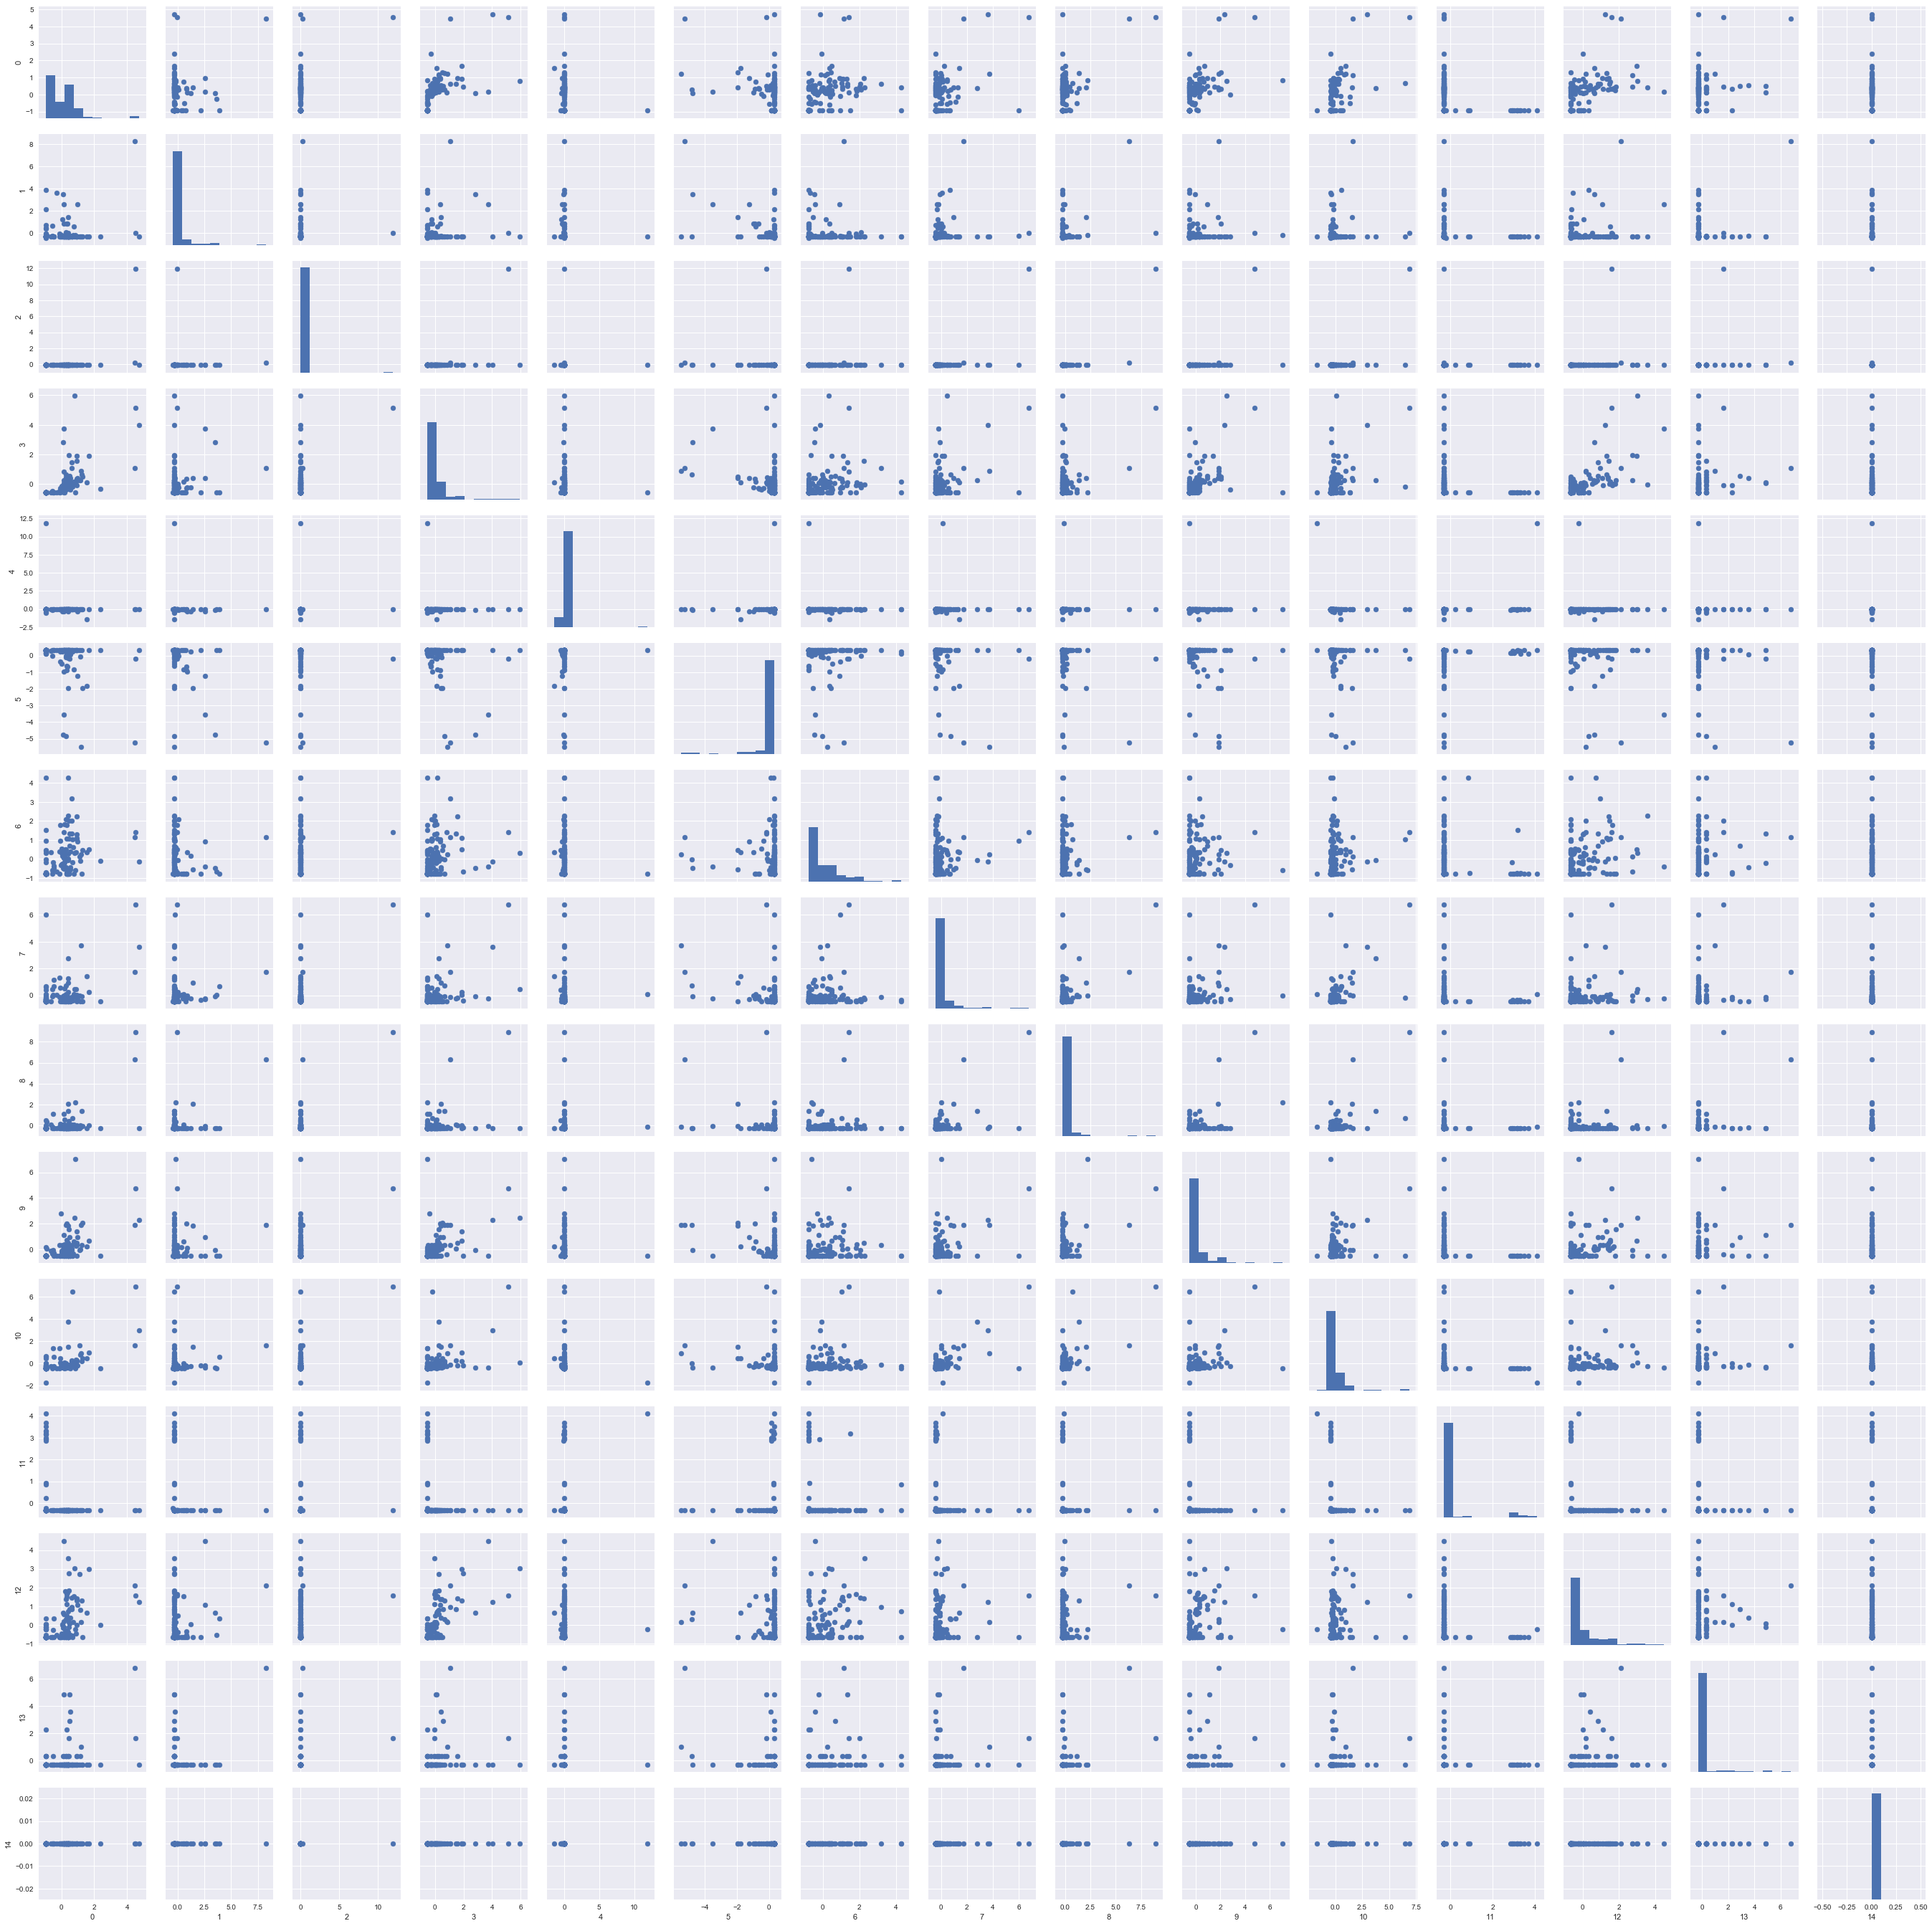

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(X_std)
pg = sns.PairGrid(df)
pg.map_diag(plt.hist)
pg.map_offdiag(plt.scatter)
plt.show()

#  Logistic Regression

In [20]:
clf_labels = \
['Logistic Regression','KNN','Random Forest','SVC','Kernel SVC','MLP']

#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Logistic Regression
scores=[]
clf_lr = LogisticRegression(penalty='l2')
pipe_lr = Pipeline([['sc',StandardScaler()],
                    ['clf',clf_lr]])
params_lr = {'clf__C':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    k_fold_outer = KFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = KFold(n_splits=5,shuffle=True,random_state=j)
        gs_lr = GridSearchCV(estimator=pipe_lr,param_grid=params_lr,
                             cv=k_fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_lr,X,y,cv=k_fold_outer,
                                      scoring='recall'))
print 'CV Recall Score of Logistic Regression: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

CV Recall Score of Logistic Regression: 0.302 +/- 0.234
Complete in 31.4 sec


#  Random Forest Classifier

In [21]:
#Random Forest Classifier
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

scores=[]
clf_rf = RandomForestClassifier(random_state=42)
pipe_rf = Pipeline([['sc',StandardScaler()],
                    ['clf',clf_rf]])
params_rf = {'clf__n_estimators':np.arange(1,11)}
t0 = time()
for i in range(N_outer):
    k_fold_outer = KFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = KFold(n_splits=5,shuffle=True,random_state=j)
        gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=params_rf,
                             cv=k_fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_rf,X,y,cv=k_fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Random Forest Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV Recall Score of Random Forest Classifier: 0.194 +/- 0.273
Complete in 188.0 sec


#  KNN Classifier

In [22]:
#KNN Classifier
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

scores=[]
clf_knn = KNeighborsClassifier()
pipe_knn = Pipeline([['sc',StandardScaler()],
                     ['clf',clf_knn]])
params_knn = {'clf__n_neighbors':np.arange(1,6)}
t0 = time()
for i in range(N_outer):
    k_fold_outer = KFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = KFold(n_splits=5,shuffle=True,random_state=j)
        gs_knn = GridSearchCV(estimator=pipe_knn,param_grid=params_knn,
                              cv=k_fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_knn,X,y,cv=k_fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of KNN Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV Recall Score of KNN Classifier: 0.141 +/- 0.189
Complete in 24.5 sec


#  Linear SVC

In [25]:
#Linear SVC
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

scores=[]
clf_svc = SVC()
pipe_svc = Pipeline([['sc',StandardScaler()],
                     ['clf',clf_svc]])
params_svc = {'clf__C':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    k_fold_outer = KFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = KFold(n_splits=5,shuffle=True,random_state=j)
        gs_svc = GridSearchCV(estimator=pipe_svc,param_grid=params_svc,
                              cv=k_fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_svc,X,y,cv=k_fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Linear SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV Recall Score of Linear SVC: 0.105 +/- 0.145
Complete in 31.3 sec


#  Kernel SVC

In [ ]:
#Kernel SVC
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

scores=[]
clf_ksvc = SVC(kernel='rbf')
pipe_ksvc = Pipeline([['sc',StandardScaler()],
                     ['clf',clf_ksvc]])
params_ksvc = {'clf__C':10.0**np.arange(-4,4),'clf__gamma':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    k_fold_outer = KFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = KFold(n_splits=5,shuffle=True,random_state=j)
        gs_ksvc = GridSearchCV(estimator=pipe_ksvc,param_grid=params_ksvc,
                               cv=k_fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_ksvc,X,y,cv=k_fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Kernel SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

/Users/Raga/anaconda/envs/enron/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
